### 데이터 전처리
#### step 1. 데이터 다운로드
- 아래의 링크에서 korean-english-park.train.tar.gz를 다운 받아 데이터 확보   

    [한영 병렬 데이터](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
    
$ wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz


$ tar -xzvf korean-english-park.train.tar.gz

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

from konlpy.tag import Mecab

import time
import re
import os
import io

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


In [2]:
# 한국어 말뭉치 사용을 위한 한국어를 지원하는 폰트로 변경

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

#### step 2. 데이터 정제
1. set을 이용해서 중복된 데이터를 제거 -> 중복을 제거한 데이터를 cleaned_corpus에 저장
2. 한글에 적용할 수 있는 정규식을 이용해서 preprocessing()함수를 정의
3. 타겟 언어인 영문에 \<start> 토큰과 \<end> 토큰을 추가하고 split()함수를 이용해서 토큰화 -> 한글 토큰화는 KoNLPy의 mecab 클래스를 사용

- 시간 단축을 위해서 cealned_corpus로부터 토큰의 길이가 40이하인 데이터를 선별해서 eng_corpus와 kor_corpus를 각각 구축

In [3]:
# 데이터 확인
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

# 한글 데이터 확인
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size:", len(raw_ko))
print("Data Size:", len(raw_en))


print("Example:")
for sen_ko, sen_en in zip(raw_ko[0:100][::20], raw_en[0:100][::20]): 
    print(">>", sen_ko)
    print("   ", sen_en)

Data Size: 94123
Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
    Much of personal computing is about "can you top this?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
    Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
    “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
    Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
    Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the he

In [4]:
# 중복 제거 
cleaned_corpus = list(zip(raw_ko, raw_en))
print(len(cleaned_corpus))

cleaned_corpus[:10]

94123


[('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"',
  'Much of personal computing is about "can you top this?"'),
 ('모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.',
  'so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.'),
 ('그러나 이것은 또한 책상도 필요로 하지 않는다.',
  "Like all optical mice, But it also doesn't need a desk."),
 ('79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.',
  'uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.'),
 ('정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.',
  "Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack."),
 ('이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여

In [5]:
tokenizer = Mecab()

def preprocess_sentence_ko(sentence):
    sentence = sentence.lower().strip() # 소문자 변환, 양쪽 공백 제거

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장 내의 구두점 앞뒤에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 개의 공백을 하나의 공백으로 축소
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence) #  한글, 영문자와 구두점(. ? ! ,) 이외의 모든 문자를 공백으로 대체

    sentence = sentence.strip()
    sentence = tokenizer.morphs(sentence) # 한글 토큰화는 KoNLPy의 mecab 클래스 사용
    
    return sentence #전처리된 문장을 반환 

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip() # 소문자 변환, 양쪽 공백 제거

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # 문장 내의 구두점 앞뒤에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 여러 개의 공백을 하나의 공백으로 축소
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z?.!,]+", " ", sentence) #  한글, 영문자와 구두점(. ? ! ,) 이외의 모든 문자를 공백으로 대체

    sentence = sentence.strip()
    
    # 타겟 언어인 영문에 <start> , <end> 토큰 추가 
    if s_token: # true
        sentence = '<start> ' + sentence # 문장 시작 부분에 <start> 토큰을 추가

    if e_token: # true
        sentence += ' <end>' # 문장 끝 부분에 <end> 토큰을 추가
        
    sentence = sentence.split()
    
    return sentence #전처리된 문장을 반환 

In [6]:
for pair in cleaned_corpus[:2]:
    kor, eng = pair[0], pair[1]
    print(kor)
    print(type(kor))
    print(eng)
    print(type(eng))

개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
<class 'str'>
Much of personal computing is about "can you top this?"
<class 'str'>
모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
<class 'str'>
so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
<class 'str'>


In [7]:
# 한국어와 영어의 전처리된 문장 코퍼스(corpus)를 만드는 과정
kor_corpus = [] # 한국어
eng_corpus = [] # 영어

max_len = 40

for pair in cleaned_corpus:
    kor, eng = pair[0], pair[1]
    if len(kor) <= max_len:
        kor_corpus.append(preprocess_sentence_ko(kor))
        eng_corpus.append(preprocess_sentence_en(eng, s_token=True, e_token=True))

# 100번째 문장 출력해서 확인
print("Korean:", kor_corpus[100])
print("English:", eng_corpus[100])

Korean: ['수백만', '달러', ',', '수백만', '에이커', '에', '이르', '는', '토지', '에', '대한', '댓', '가가', '지불', '되', '었', '습니다', '.']
English: ['<start>', 'nearly', 'a', 'million', 'dollars', 'and', 'millions', 'of', 'acres', 'of', 'land', 'have', 'been', 'paid', 'out', '.', '<end>']


In [8]:
for pair in kor_corpus[:2]:
    print(pair)
    print(type(pair))

['개인', '용', '컴퓨터', '사용', '의', '상당', '부분', '은', '이것', '보다', '뛰어날', '수', '있', '느냐', '?']
<class 'list'>
['그러나', '이것', '은', '또한', '책상', '도', '필요', '로', '하', '지', '않', '는다', '.']
<class 'list'>


#### step 3. 데이터 전처리: 토큰화
- 정제된 텍스트를 tokenize() 함수를 사용해 토큰화하고 텐서로 변환하고 각각의 tokenizer를 얻음
- 단어의 수는 최소 10,000 이상
- 데이터의 수가 적으므로 훈련 데이터와 검증 데이터로 따로 나누지 않음

In [9]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus) # 텍스트를 정수 시퀀스로 변환

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') # 패딩 적용

    return tensor, tokenizer # 토큰화된 시퀀스와 학습된 토크나이저를 반환

In [10]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

print("Korean Vocab Size:", len(kor_tokenizer.index_word))
print("English Vocab Size:", len(eng_tokenizer.index_word))

Korean Vocab Size: 17233
English Vocab Size: 16834


In [11]:
print(kor_tensor[100])
print(eng_tensor[100])

[1515  181    7 1515 3654    9 1138    3 2626    9  124 6450 9474  811
   34   27   29    1    0    0    0    0    0    0    0]
[   2  369    9  179 1233   11 1102    8 2951    8  645   28   40 1026
  109    1    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


### step 4. 모델 설계
-  Attention 기반 Seq2seq 모델을 설계

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)# 디코더의 hidden state를 처리
        self.w_enc = tf.keras.layers.Dense(units)# 인코더의 hidden state를 처리
        self.w_com = tf.keras.layers.Dense(1) # 어텐션 가중치를 결합하는 데 사용되는 밀집 레이어
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc) # 인코더 hidden state에 대한 가중치를 계산
        h_dec = tf.expand_dims(h_dec, 1) # 디코더 hidden state에 차원을 추가하여 broadcasting이 가능하도록 함
        h_dec = self.w_dec(h_dec) # 디코더 hidden state에 대한 가중치를 계산

        score = self.w_com(tf.nn.tanh(h_dec + h_enc)) # 어텐션 스코어를 계산
        #  디코더 hidden state와 인코더 hidden state 간의 유사도를 나타냄
        
        attn = tf.nn.softmax(score, axis=1) # 각 인코더의 hidden state에 대한 가중치가 얻어냄
  
        context_vec = attn * h_enc # 어텐션 가중치를 사용하여 인코더 hidden state를 가중 평균
        context_vec = tf.reduce_sum(context_vec, axis=1) # 시퀀스 길이에 따라 가중 평균을 합산하여 컨텍스트 벡터를 계산

        return context_vec, attn # 계산된 컨텍스트 벡터와 어텐션 가중치를 반환

In [13]:
class Encoder(tf.keras.Model):
    # vocab_size: 어휘 사전의 크기, 즉 모델이 다루는 고유 단어의 수
    # embedding_dim: 임베딩 차원, 즉 각 단어를 나타내는 벡터의 크기
    def __init__(self, vocab_size, embedding_dim, enc_units, dropout_rate, recurrent_dropout):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units # enc_units: GRU 레이어의 유닛 수, 즉 GRU 레이어의 출력 차원
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # 주어진 단어 인덱스를 임베딩 벡터로 변환
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True, # 모든 시점의 출력을 반환하도록 설정
                                      dropout = dropout_rate,
                                      recurrent_dropout = recurrent_dropout) 
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out)
        out = self.gru(out)
        
        return out

In [14]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, dropout_rate, recurrent_dropout):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       dropout=dropout_rate,
                                       recurrent_dropout=recurrent_dropout_rate # 순환 드롭아웃 추가
                                      )
        # 출력 레이어로, 디코더의 출력을 어휘 크기에 맞게 변환
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # Bahdanau 어텐션 메커니즘을 사용하는 어텐션 레이어를 생성
        self.attention = BahdanauAttention(self.dec_units)

        # 드롭아웃 레이어 추가
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x, h_dec, enc_out):
        # h_dec : 디코더의 이전 시점의 hidden state
        # enc_out: 인코더의 출력으로, 모든 시점에서의 인코더의 hidden state
        
        #  Bahdanau 어텐션 레이어를 사용하여 현재 디코더의 hidden state와 인코더의 hidden state 간의 어텐션 가중치 및 컨텍스트 벡터를 계산
        context_vec, attn = self.attention(enc_out, h_dec) 

        # 임베딩 및 어텐션 가중치 추가
        out = self.embedding(x)
        # 어텐션 가중치를 현재 입력에 추가
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        # 일반 드롭아웃을 GRU 입력에 추가
        out = self.dropout(out)
        
        # GRU 레이어 실행
        #어텐션을 추가한 입력을 GRU 레이어에 전달하여 디코더의 현재 시점의 출력과 hidden state를 얻음
        out, h_dec = self.gru(out)
        
        # 출력 레이어 젹용
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out) # 최종 출력 생성

        return out, h_dec, attn

In [15]:
# 하이퍼파라미터 정의
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512
dropout_rate = 0.2
recurrent_dropout_rate = 0.2

# 인코더 및 디코더 모델 초기화
encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units, dropout_rate, recurrent_dropout_rate)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units, dropout_rate, recurrent_dropout_rate)

# 샘플 입력 및 인코더 출력 확인
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len)) # 랜덤한 인코더 입력 시퀀스를 생성
sample_output = encoder(sample_enc) # 인코더에 랜덤한 입력을 전달하여 인코더 출력을 확인

print ('Encoder Output:', sample_output.shape)

# 샘플 디코더 출력 및 어텐션 확인
sample_state = tf.random.uniform((BATCH_SIZE, units))

# 디코더에 랜덤한 입력과 hidden state를 전달하여 디코더 출력 및 어텐션 가중치를 확인
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 16835)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


####  step 5. 모델 훈련

In [16]:
# 옵티마이저 및 손실함수 초기화
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # 신경망 출력이 로짓인 경우에 사용
# reduction='none'은 손실을 각 샘플에 대해 계산하고, 나중에 모든 샘플에 대한 평균을 계산할 때 사용

def loss_function(real, pred):
    # 패딩된 부분은 고려하지 않도록 하기 위해 패딩된 부분에 대한 마스크를 생성
    # 패딩은 정수 0으로 표현되고, 이를 기준으로 마스크를 생성
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    # 실제 레이블과 모델의 예측값 간의 손실을 계산
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype) # 마스크를 손실 데이터 형식으로 변환
    loss *= mask # 손실에 마스크를 곱하여 패딩된 부분의 손실을 0으로 만듬
    
    return tf.reduce_mean(loss)

#### train_step 구현
- train_step()은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수
- 학습 과정

    1) Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성  
    
    2) t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:, -1]  
    
    3) Decoder에 입력으로 전달할 \<start> 토큰 문장 생성  
    
    4) \<start> 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측. pred  
    
    5) 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어 X)  
    
    6) 반복!

In [17]:
@tf.function

# src: 입력 소스 문장의 텐서
# tgt: 목표 타겟 문장의 텐서
# dec_tok: 디코더의 토크나이저 객체
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    # 그래디언트 계산
    with tf.GradientTape() as tape: 
        enc_out = encoder(src) #  주어진 소스 문장에 대해 인코더를 실행하여 인코더 출력을 얻음
        h_dec = enc_out[:, -1] # 디코더의 초기 hidden state를 인코더 출력의 마지막 시점으로 설정
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) # start 토큰 추가

        # 디코딩 루프 : 디코더를 반복적으로 실행해서 예측을 생성하고 손실을 계산
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred) # 각 시점에서의 손실을 누적
            
            # 다음 시점의 디코더 입력으로 현재 타임 스텝의 실제 값을 사용
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1])) # 전체 손실을 타임 스텝 수로 나누어 배치 손실 계산

    variables = encoder.trainable_variables + decoder.trainable_variables # 훈련 가능한 변수 가져옴
    gradients = tape.gradient(loss, variables) # 그래디언트를 계산
    optimizer.apply_gradients(zip(gradients, variables)) # 옵티마이저를 사용해서 모델의 기울기를 업데이트
    
    return batch_loss # 배치 손실 반환

이러한 훈련 스텝 함수는 Seq2Seq 모델의 훈련 과정 중 한 스텝을 수행하며, 주어진 데이터 배치에 대해 손실을 계산하고 모델을 업데이트함

In [18]:
# Validation Set을 사용하는 eval_step() 함수를 정의
# # eval_step() 정의하기

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [19]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence_ko(sentence)
    inputs = kor_tokenizer.texts_to_sequences([str(sentence).split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(str(result).split()), :len(str(sentence).split())]
    plot_attention(attention, str(sentence).split(), str(result).split(' '))



In [20]:
print(eng_tokenizer.word_index)

{'.': 1, '<start>': 2, '<end>': 3, 'the': 4, ',': 5, 'to': 6, 'in': 7, 'of': 8, 'a': 9, 's': 10, 'and': 11, 'is': 12, 'on': 13, 'it': 14, 'was': 15, 'for': 16, 'will': 17, 'said': 18, 'be': 19, 'with': 20, 'that': 21, 'he': 22, 'by': 23, 'his': 24, 'has': 25, 'at': 26, 'are': 27, 'have': 28, 'korea': 29, 'as': 30, 'were': 31, '?': 32, 'not': 33, 'from': 34, 'other': 35, 'they': 36, 'but': 37, 'this': 38, 'an': 39, 'been': 40, 'women': 41, 'lee': 42, 'also': 43, 'i': 44, 'likely': 45, 'takes': 46, 'ban': 47, 'hong': 48, 'living': 49, 'aid': 50, 'cash': 51, 'kong': 52, 'michael': 53, 'one': 54, 'she': 55, 'about': 56, 'flu': 57, 'double': 58, 'civil': 59, 'host': 60, 'reduced': 61, 'jackson': 62, 'explain': 63, 'we': 64, 'g': 65, 'flying': 66, 'promise': 67, 'african': 68, 'sets': 69, 'shift': 70, 'draft': 71, 'debut': 72, 'kenya': 73, 'forecasters': 74, 'people': 75, 'cd': 76, 'bearing': 77, 'servants': 78, 'more': 79, 'orphanage': 80, 'thwart': 81, 'cage': 82, 'brunt': 83, 'songdo': 84

In [21]:
from tqdm import tqdm    # 작업 진행 상태 모니터링
import random

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    # : 인덱스 리스트를 생성하여 데이터셋을 미니배치로 나누기 위한 인덱스를 미리 계산
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE)) # 각 배치의 시작 인덱스
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm
    
    # 미니 배치 순회
    for (batch, idx) in enumerate(t): 
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE],
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        # tqdm에 현재 에포크 번호를 표시
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        # 현재까지의 평균 손실을 표시
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 384/384 [05:32<00:00,  1.16it/s, Loss 0.3626]


이러한 훈련 루프를 통해 모델은 주어진 에포크 동안 전체 훈련 데이터셋에 대해 반복적으로 학습되며, tqdm을 사용하여 진행 상태를 모니터링함

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: the actress nomination . <end> 


/tmp/ipykernel_277/4244822761.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_277/4244822761.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


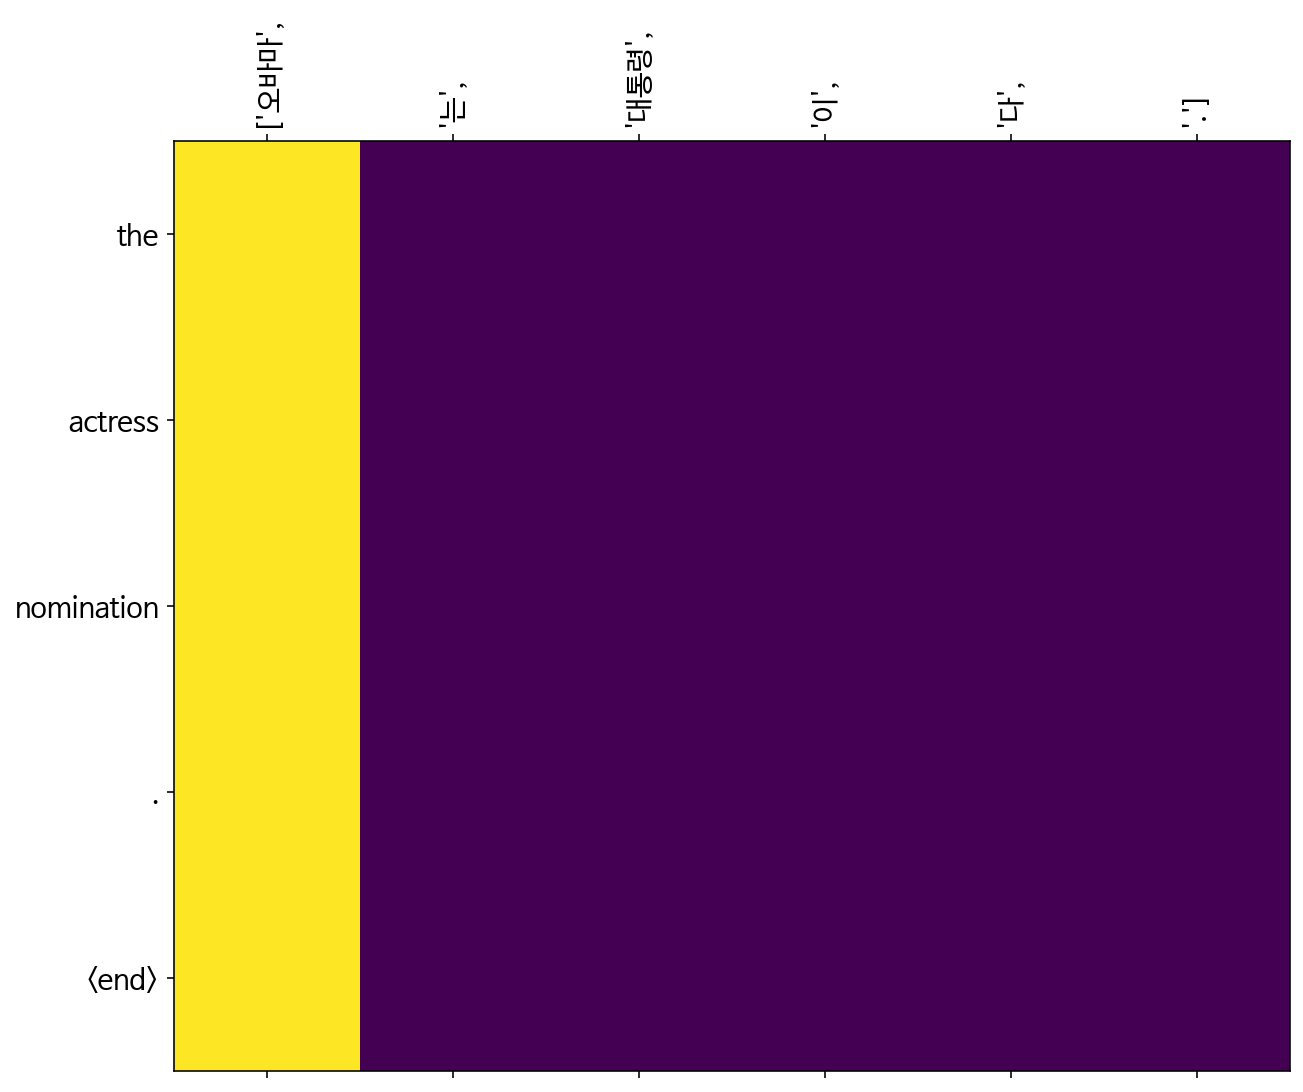

In [22]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: the actress nomination . <end> 


/tmp/ipykernel_277/4244822761.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_277/4244822761.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


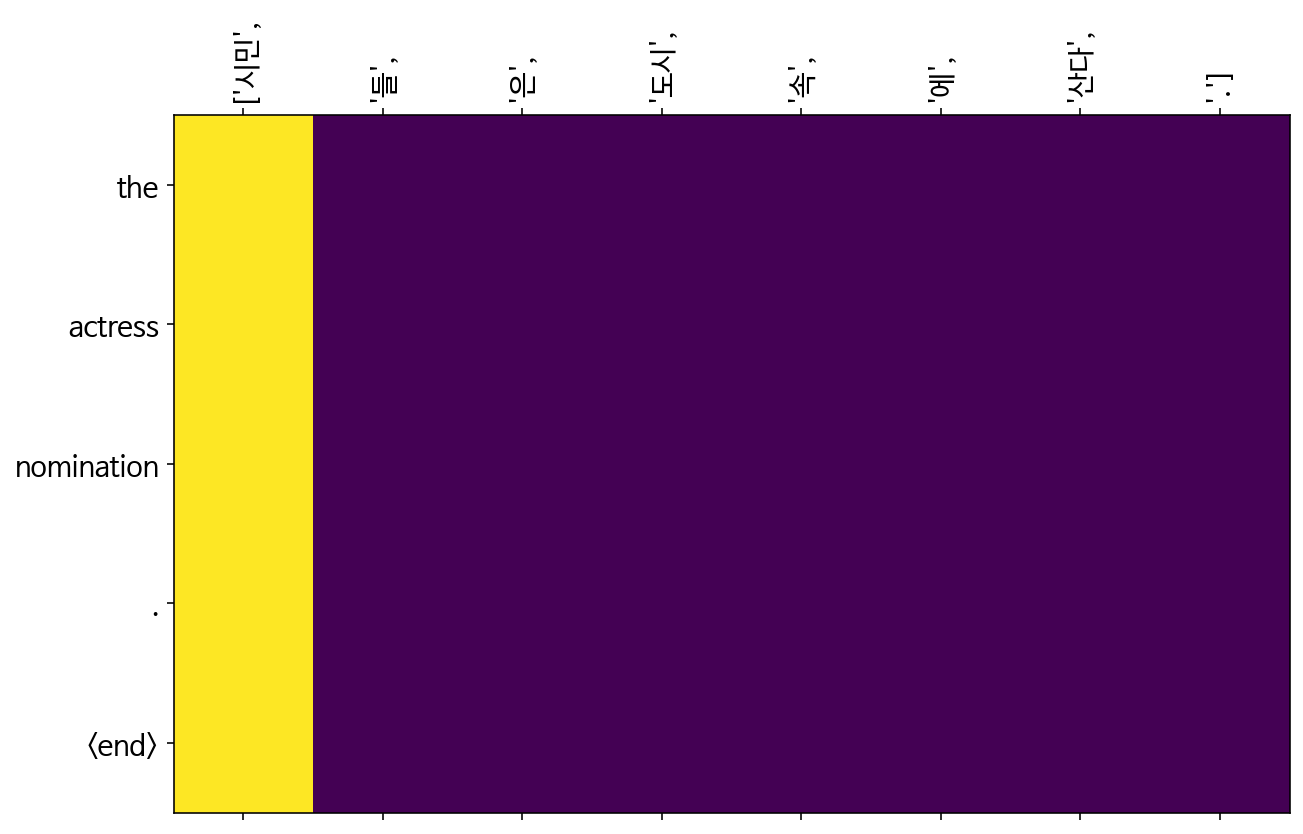

In [23]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the actress nomination . <end> 


/tmp/ipykernel_277/4244822761.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_277/4244822761.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


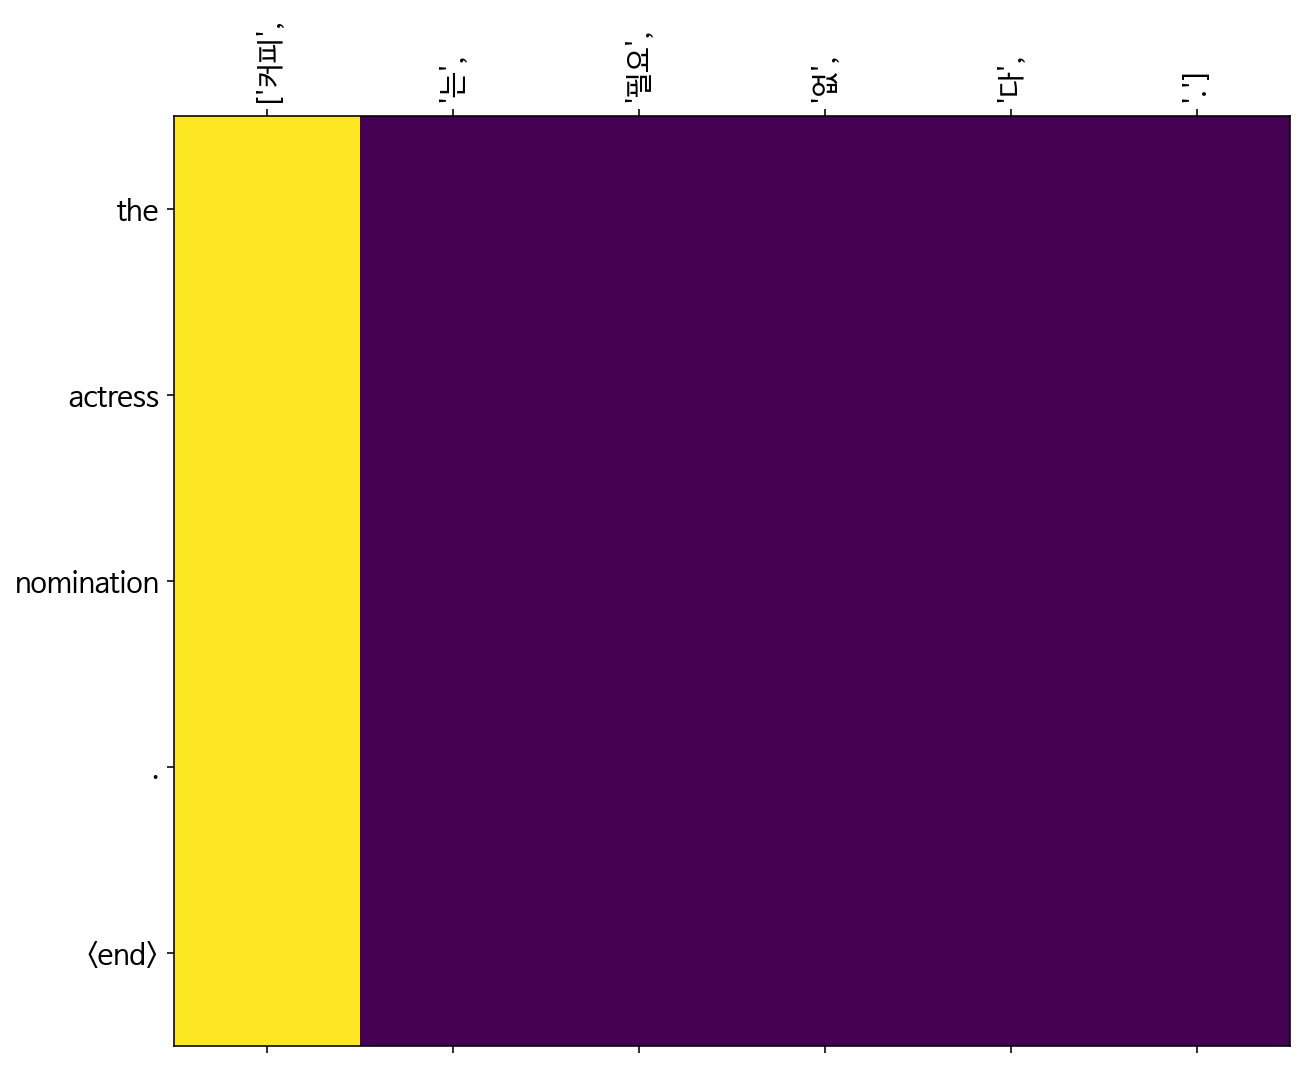

In [24]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the actress nomination . <end> 


/tmp/ipykernel_277/4244822761.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_277/4244822761.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


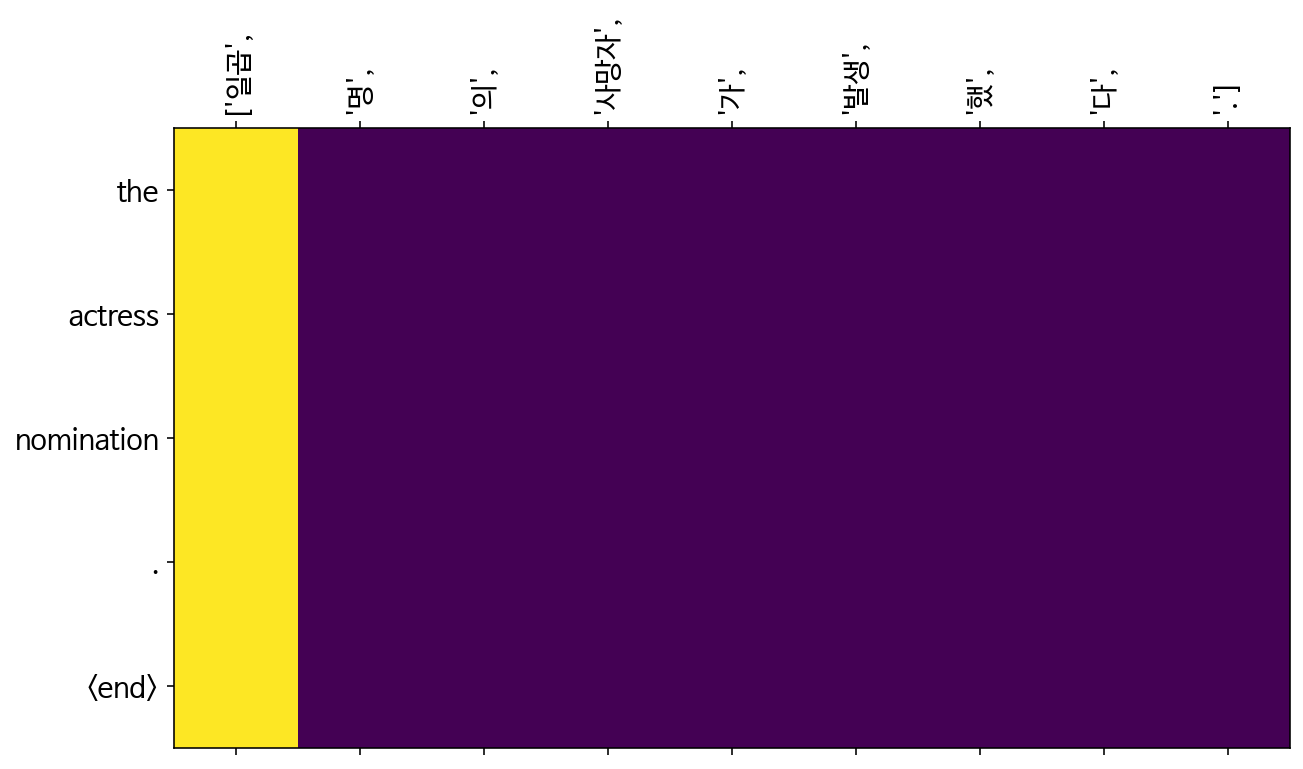

In [25]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

#### epoch :10, Dropout 적용 안했을 때
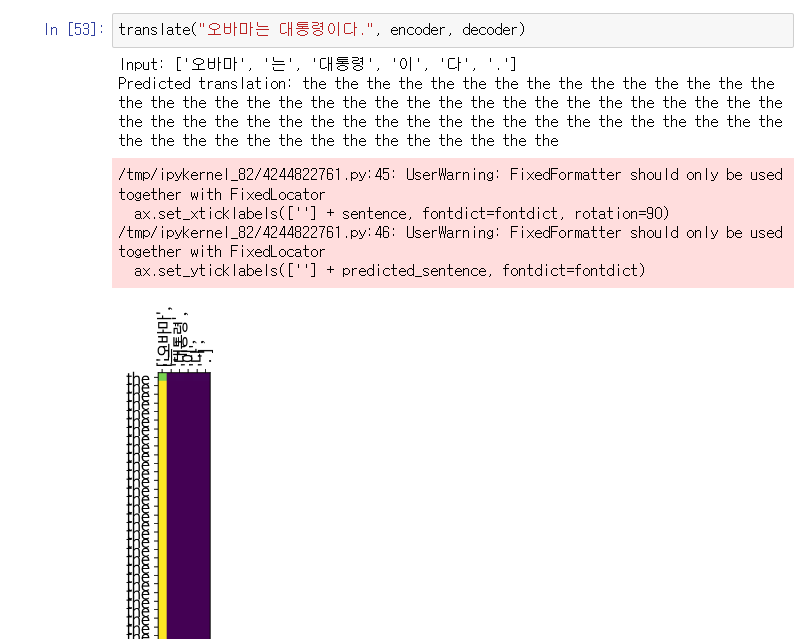

#### epoch=10, Dropout 적용
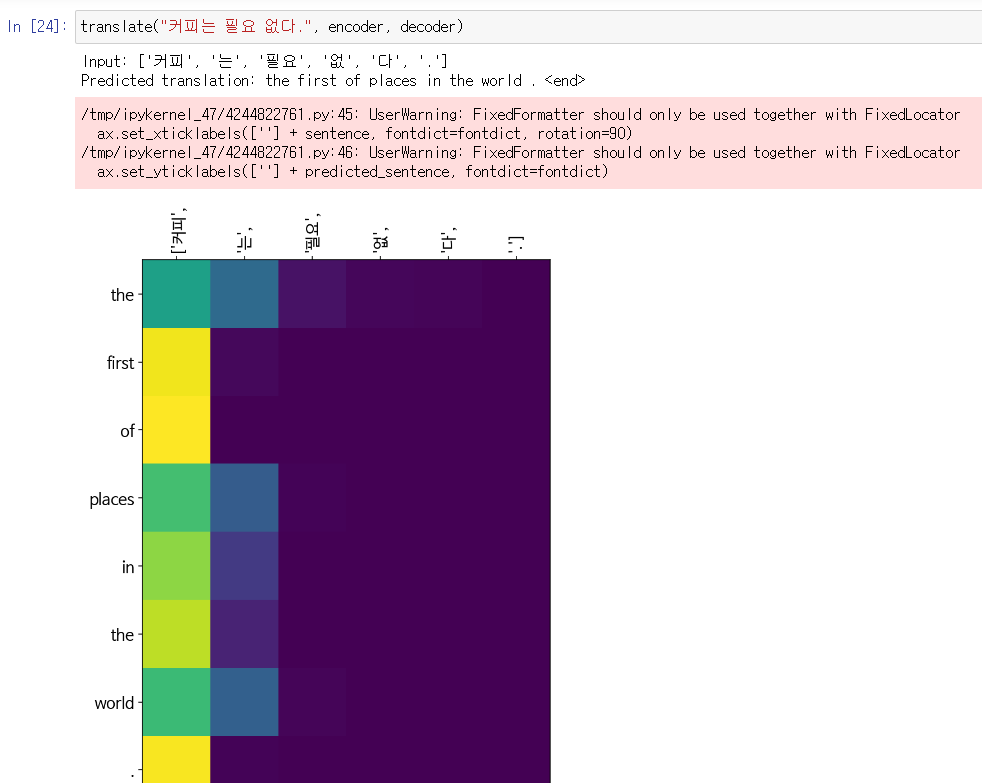

#### epoch=15
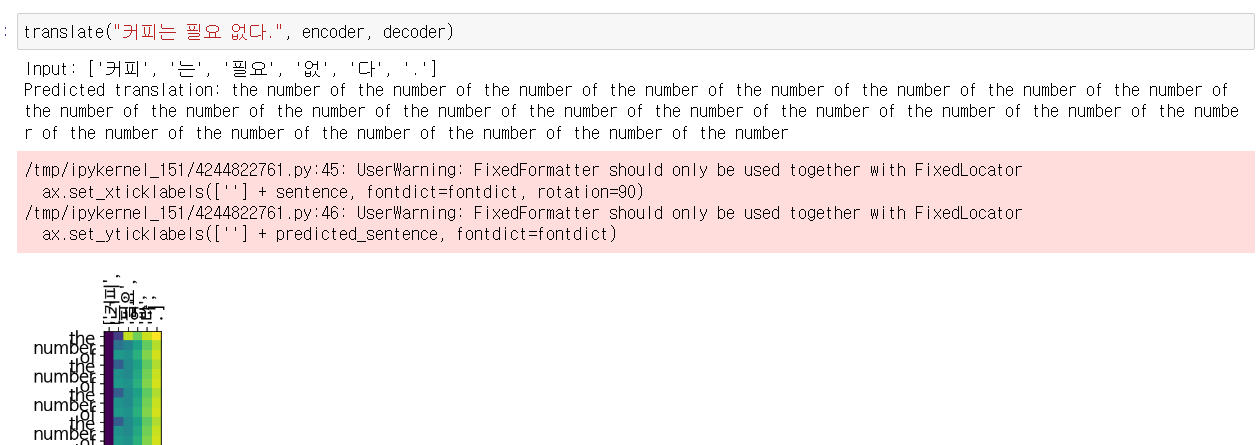

#### epoch = 20
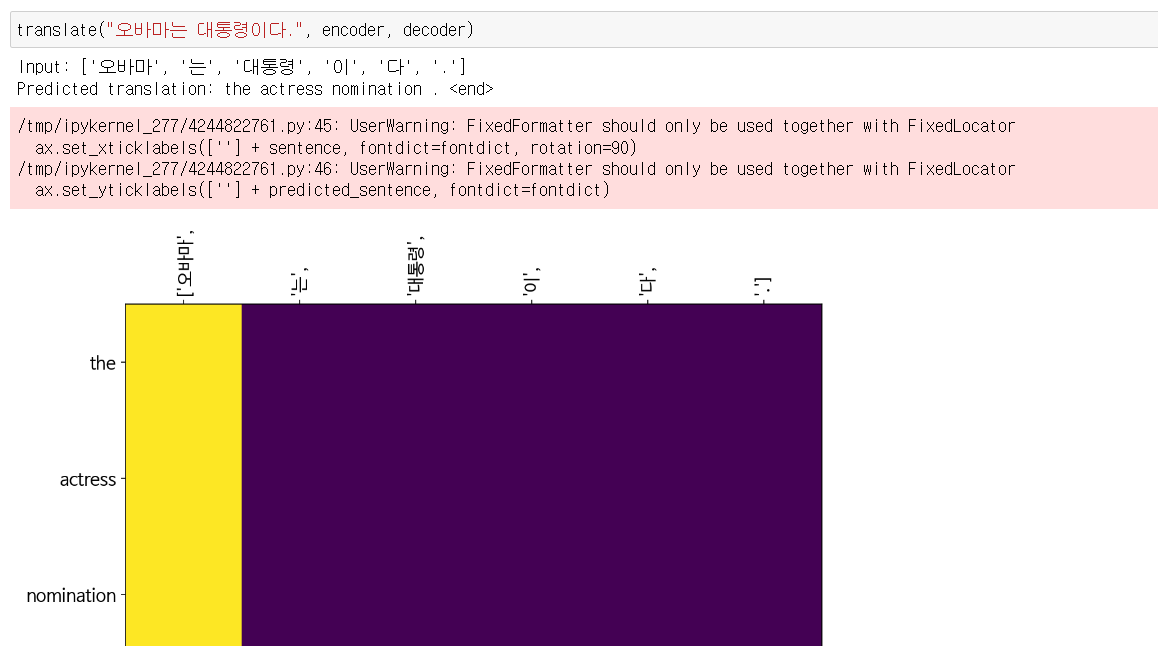

## 회고

- epoch 수를 고정하고 dropout 적용 여부를 비교했다
    - dropout을 적용 안했을 때, the만 출력 결과가 나와서 당황했다
    - dropout을 적용 했을 때, 다양한 단어가 나왔지만 고정된 결과만 출력되었다
- 배치 사이즈, 학습 수, padding 방식 등 다르게 해서 실험을 진행해보아야겠다